Given code that can extract the contents of the inner rectangles (boxes), we can determine whether the 
contents have changed.

Here, take an image of the previous box and see whether the same contents are still there.  The idea is that 
a name does not only get erased, it may also be replaced.  We hope to find something more robust than the ink
method (exploration-2). 


In [1]:
LIVENOTEBOOK = True
import cv2
cv2.__version__
import extract_blue_grid
get_contents = extract_blue_grid.get_contents


In [8]:
def get_content1(imagepath):
    "return 2nd box and contour from get_contents"
    boxes, contours = get_contents(imagepath)
    return boxes[1], contours[1]

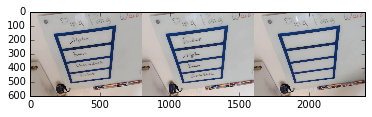

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim 
def imshow(img):  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

imwriting1 = cv2.imread("../reference/frame276.png")
imwriting2 = cv2.imread("../reference/frame280.png")
imempty = cv2.imread("../reference/frame272.png")


if LIVENOTEBOOK:
    %matplotlib inline
    # test plotting
    imshow(np.concatenate([imwriting1,imwriting2,imempty], axis=1))

In [3]:
# not used:
def threshold_boxes(boxes):
    """Given a list of images, adaptive threshold each image"""
    output = []
    for img in boxes:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        dst = cv2.adaptiveThreshold(img, 160, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 2)
        output.append(dst)
    return output


Found 3 outer contours
Found shape with sides: 13
Found shape with sides: 12
Found shape with sides: 4
-- Found: 445 x 409
Found 3 outer contours
Found shape with sides: 12
Found shape with sides: 12
Found shape with sides: 4
-- Found: 445 x 409
Found 3 outer contours
Found shape with sides: 14
Found shape with sides: 12
Found shape with sides: 4
-- Found: 445 x 409


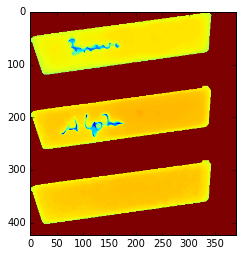

In [9]:
%matplotlib inline
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))

writing1,contours1 = get_content1("../reference/frame276.png")
writing1 = cv2.morphologyEx(writing1, cv2.MORPH_OPEN, kernel)
writing1 = cv2.cvtColor(writing1, cv2.COLOR_BGR2GRAY)
#writing1 = cv2.adaptiveThreshold(writing1, 160, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 2)


writing2,contours2 = get_content1("../reference/frame280.png")
writing2 = cv2.morphologyEx(writing2, cv2.MORPH_OPEN, kernel)
writing2 = cv2.cvtColor(writing2, cv2.COLOR_BGR2GRAY)
#writing2 = cv2.adaptiveThreshold(writing2, 160, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 2)

empty,contoursempty = get_content1("../reference/frame272.png")
empty = cv2.morphologyEx(empty, cv2.MORPH_OPEN, kernel)
empty = cv2.cvtColor(empty, cv2.COLOR_BGR2GRAY)
#empty = cv2.adaptiveThreshold(empty, 160, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 2)


plt.imshow(np.concatenate([writing1,writing2,empty]))
#plt.imshow(writing1)
#writing1.shape, writing2.shape, empty.shape


Found 4 outer contours
Found shape with sides: 4
-- Rejected rectangle: 2 x 2
Found shape with sides: 15
Found shape with sides: 13
Found shape with sides: 4
-- Found: 445 x 409
Found 3 outer contours
Found shape with sides: 15
Found shape with sides: 12
Found shape with sides: 4
-- Found: 445 x 409


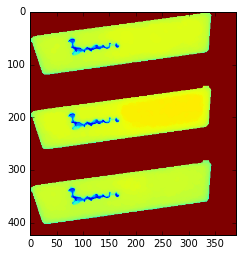

In [11]:
writingb, contoursb = get_content1("../reference/frame274.png")
writingb = cv2.morphologyEx(writingb, cv2.MORPH_OPEN, kernel)
writingb = cv2.cvtColor(writingb, cv2.COLOR_BGR2GRAY)

writingc, contoursc = get_content1("../reference/frame275.png")
writingc = cv2.morphologyEx(writingc, cv2.MORPH_OPEN, kernel)
writingc = cv2.cvtColor(writingc, cv2.COLOR_BGR2GRAY)

plt.imshow(np.concatenate([writing1,writingb,writingc]))

In [ ]:
# matching does not work on a whole image: it looks like it does:
img = writing1.copy()
method = cv2.TM_SQDIFF
w, h = writing1.shape[::-1]
res = cv2.matchTemplate(writingb,writing1,method)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
top_left = min_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(img,top_left, bottom_right, 255, 2)
print(top_left, bottom_right,  "%2.2e" % min_val )
plt.imshow(img)

In [ ]:
# but it another word too
img = writing2.copy()
method = cv2.TM_SQDIFF
w, h = img.shape[::-1]
res = cv2.matchTemplate(img,writing1,method)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
top_left = min_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(img,top_left, bottom_right, 255, 2)
print(top_left, bottom_right, "%2.2e" % min_val)
plt.imshow(img)

In [ ]:
# and it matches empty just as well..
img = empty.copy()
method = cv2.TM_SQDIFF
w, h = img.shape[::-1]
res = cv2.matchTemplate(img,writing1,method)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
top_left = min_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(img,top_left, bottom_right, 255, 2)
print(top_left, bottom_right, "%2.2e" % min_val)
plt.imshow(img)

so the first result (2 up ) sounds like the whole img got recognized, great.  but retrying it with another word and empty shows we recognize almost everything.  There are variations in value but they are pretty close, given all the noise around the image.

i think we should:
- straighten out the image
- take a template just around the word bravo
- then match against a straightened target image
- the straightening may not be nec (may you write crooked) but template matching is on rects.


### Let's try this out with a hand made template without straightening


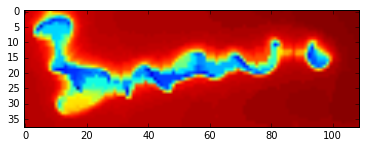

In [13]:
template = cv2.imread('template.png')  # used gimp to cut it 
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
plt.imshow(template)

best val, res.min, res.max: -3.542526364326477e-07 -0.354253 0.999997


0.9999972581863403

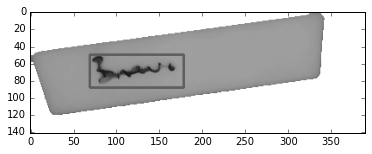

In [14]:
def frame_img(img, dim):
    "put image in a black frame so resulting image has shape dim"
    framed = np.zeros(dim, dtype=img.dtype)
    jx, jy = np.trunc((np.array(dim)  - np.array(img.shape))/2).astype(int)
    assert jx>0 and jy>0, "Image must be smaller than desired dimensions"
    framed[jx:jx+img.shape[0], jy:jy+img.shape[1]] = img
    return framed


def locate_template(img, template):
    "Find template in image and produce stats + image "
    img1 = img.copy()
    # method = cv2.TM_SQDIFF, tried this first, works less well and gives numbers that are harder to 
    # interpret.  For sqdiff, lower is better and non-id copies were around 1e6, alpha around 4e6
    method = cv2.TM_CCOEFF_NORMED
    w, h = template.shape[::-1]

    res = cv2.matchTemplate(template,img1,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(img1,top_left, bottom_right, 128, 2)
    print("best val, res.min, res.max:", min_val/1e6, res.min(), res.max())
    #framed = frame_img(res, img1.shape)
    # this does not work because the scale (min-max) of framed is very different from res. 
    #plt.imshow(np.concatenate([img1.astype(np.float32)*np.mean(framed), framed.astype(np.float32)]), cmap="gray")
    plt.imshow(img1.astype(np.float32), cmap="gray")
    return max_val, img1
    
value, _ = locate_template(writing1, template)
value

In [ ]:
# for SQDIFF this one scored quite high, with COEFF_NORMED it is fine.
value, _ = locate_template(writingb, template)
"value %2.2e" % value


In [ ]:
value, _ = locate_template(writingc, template)
"value %2.2e" % value

In [ ]:
value, _ = locate_template(writing2, template)
"value %2.2e" % value

In [ ]:
value, _ = locate_template(empty, template)
"value %2.2e" % value

## So we have to find that template and we are in business

In [15]:
contours1.shape # shape of box shown in writing1

(253, 1, 2)

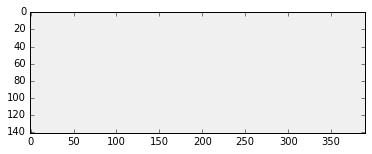

In [44]:

img = np.zeros((141, 390,3), dtype=np.uint8)

img[:]=(240,240,240)
cv2.drawContours(img, [contours1], -1, (8,255,5), 3)
imshow(img)

In [46]:
c = contours1
peri = 0.01 * cv2.arcLength(c, True)  # approximate such that new perimeter is 1% of old one
approx = cv2.approxPolyDP(c, peri, True)
print(approx)

[[[579 243]]

 [[566 317]]

 [[264 359]]

 [[236 292]]

 [[260 279]]]
